### TODO
- 空手クラブでの可視化
- polblogsでの可視化（最大連結成分）
- SBMによる合成データでコミュニティー内とコミュニティ間の密度を変えて可視化（0.5 ~ 1.0）

**実験について**
- 重みなし無向グラフとして扱う
- 初期条件を複数用意し，最大尤度のモデルを使用
- 可視化について
    - 元データ
    - DCSBMの学習表現
    - 推定データと元データのエッジの有無を一致させたもの

**次元削減**
- UMAP, T-SNEで可視化
- UMAPのパラメータ
    - n_neighborn : 平均次数
    - metric : ユークリッド距離，コサイン類似度の両方

In [1]:
import sys
import os 
from dotenv import load_dotenv
load_dotenv()
WORK_DIR = os.environ.get("WORK_DIR")
sys.path.append(WORK_DIR)

In [2]:
print(WORK_DIR)
print(sys.path)

/CommunityEmbeddingResearch
['/usr/local/lib/python311.zip', '/usr/local/lib/python3.11', '/usr/local/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/site-packages', '/CommunityEmbeddingResearch']


In [3]:
import networkx as nx
from collections import defaultdict
import numpy as np
from src.algorithm.DCSBM.DCSBM_NW import DCSBM
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
from src.data.make_polblogs_graph import make_polblogs_graph

### 空手クラブ

In [4]:
# 空手クラブのネットワークを読み込む
G = nx.karate_club_graph()
club_labels = nx.get_node_attributes(G, 'club')
true_communities = [1 if club_labels[node] == 'Mr. Hi' else 0 for node in G.nodes()]

In [5]:
# 確率ブロックモデルの学習
max_ll = -1e9
max_seed = -1

for seed in range(0,20):
    dcsbm = DCSBM(G, 2, seed)
    dcsbm.fit() 
    ll: float = dcsbm.log_likelihood()
    if ll > max_ll:
        max_ll = ll
        max_seed = seed

print(max_ll)
print(max_seed)

  2%|▏         | 2/100 [00:00<00:00, 463.20it/s]

-739.3884041633212
19


In [6]:
# 最も尤度関数の値の大きい学習結果を採用
best_dcsbm = DCSBM(G, 2, max_seed)
best_dcsbm.fit()
w = best_dcsbm.get_w()
theta = best_dcsbm.get_theta()
communities = best_dcsbm.get_communities()
A = best_dcsbm.calculate_adjancency_matrix_sub()
avdg = int(best_dcsbm.get_mean_degree())

N = G.number_of_nodes()
A_expected = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        A_expected[i][j] = theta[i]*theta[j]*w[communities[i]][communities[j]]

A_expected_zero = A_expected*A

print(f"平均次数：{avdg}")
A

  2%|▏         | 2/100 [00:00<00:00, 138.45it/s]

平均次数：4


array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [7]:
self_degree = []
for i in range(len(A)):
    self_degree.append(A[i][i])

print(*self_degree)

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


**UMAP（ユークリッド距離）**

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


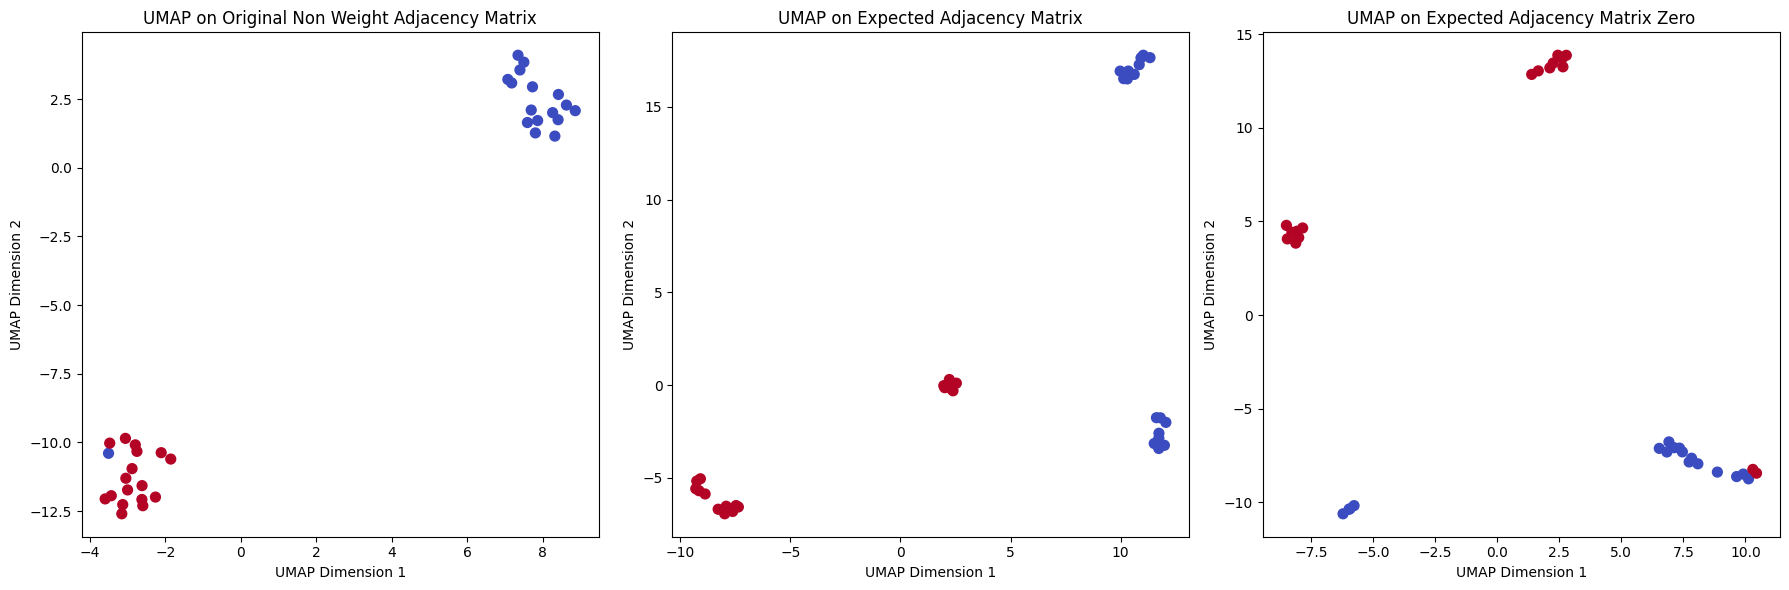

In [8]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="euclidean").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="euclidean").fit_transform(A_expected)
embedding_expected_zero = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="euclidean").fit_transform(A_expected_zero)

# 結果をプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=communities, cmap='coolwarm', s=50)
ax1.set_title('UMAP on Original Non Weight Adjacency Matrix')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
ax2.set_title('UMAP on Expected Adjacency Matrix')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

ax3.scatter(embedding_expected_zero[:, 0], embedding_expected_zero[:, 1], c=communities, cmap='coolwarm', s=50)
ax3.set_title('UMAP on Expected Adjacency Matrix Zero')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


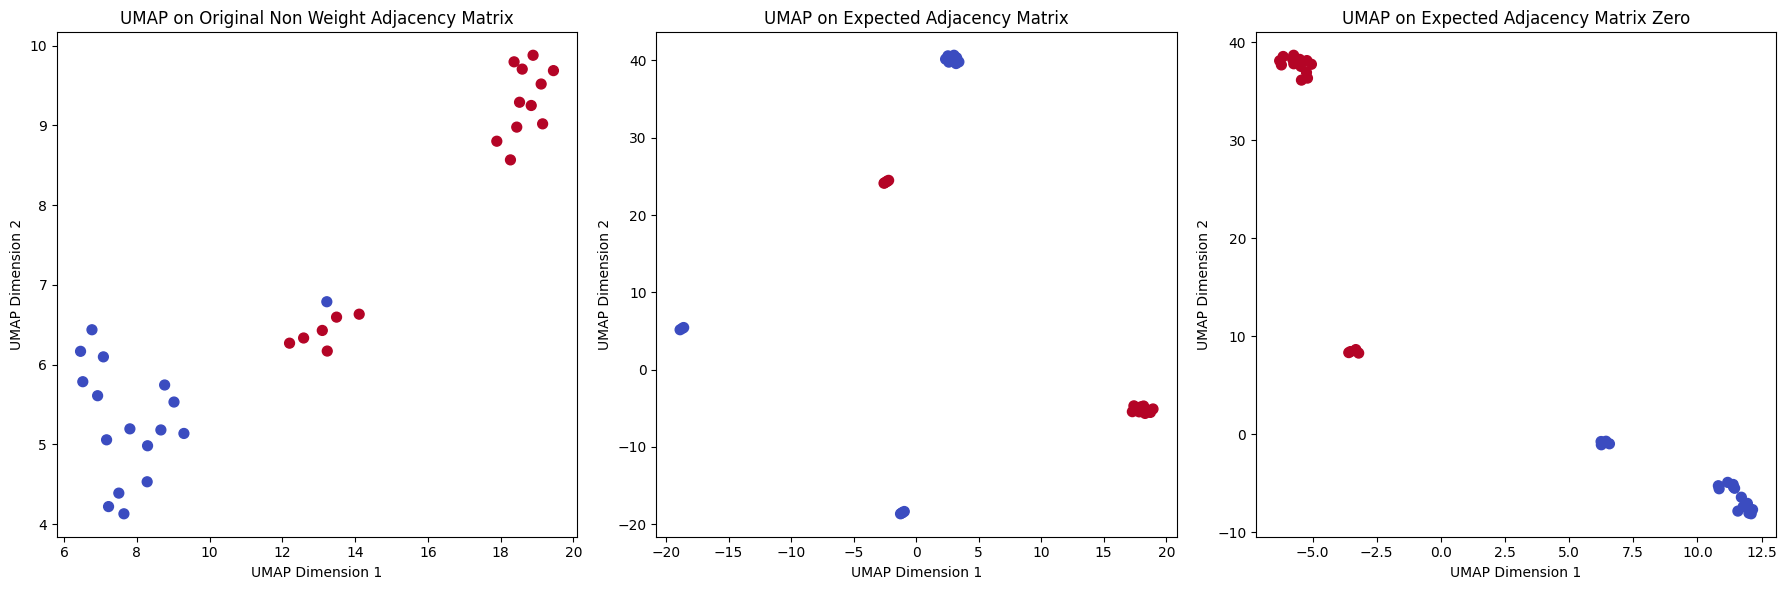

In [9]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected)
embedding_expected_zero = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected_zero)

# 結果をプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=communities, cmap='coolwarm', s=50)
ax1.set_title('UMAP on Original Non Weight Adjacency Matrix')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
ax2.set_title('UMAP on Expected Adjacency Matrix')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

ax3.scatter(embedding_expected_zero[:, 0], embedding_expected_zero[:, 1], c=communities, cmap='coolwarm', s=50)
ax3.set_title('UMAP on Expected Adjacency Matrix Zero')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


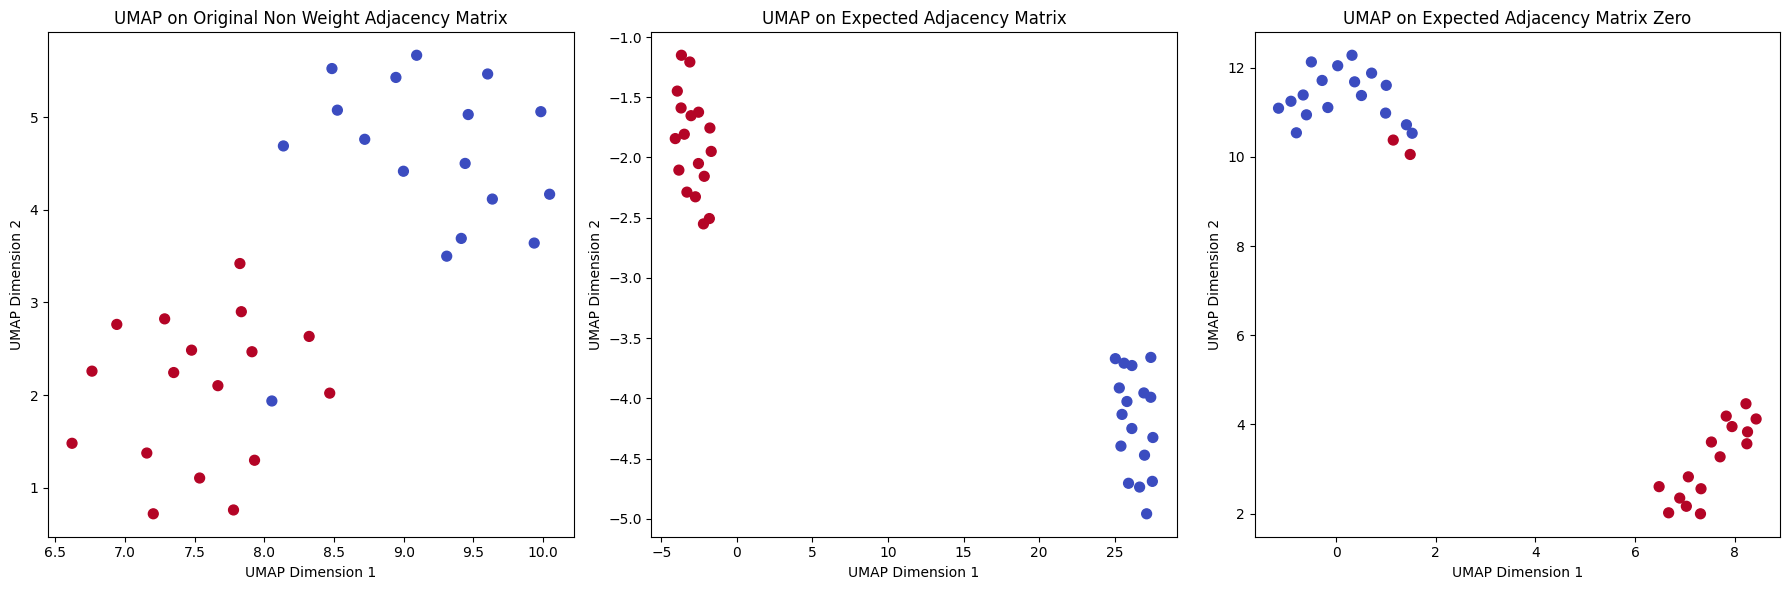

In [10]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, random_state=22, metric="euclidean").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, random_state=22, metric="euclidean").fit_transform(A_expected)
embedding_expected_zero = umap.UMAP(n_components=2, random_state=22, metric="euclidean").fit_transform(A_expected_zero)

# 結果をプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=communities, cmap='coolwarm', s=50)
ax1.set_title('UMAP on Original Non Weight Adjacency Matrix')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
ax2.set_title('UMAP on Expected Adjacency Matrix')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

ax3.scatter(embedding_expected_zero[:, 0], embedding_expected_zero[:, 1], c=communities, cmap='coolwarm', s=50)
ax3.set_title('UMAP on Expected Adjacency Matrix Zero')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

**UMAP（コサイン類似度）**

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


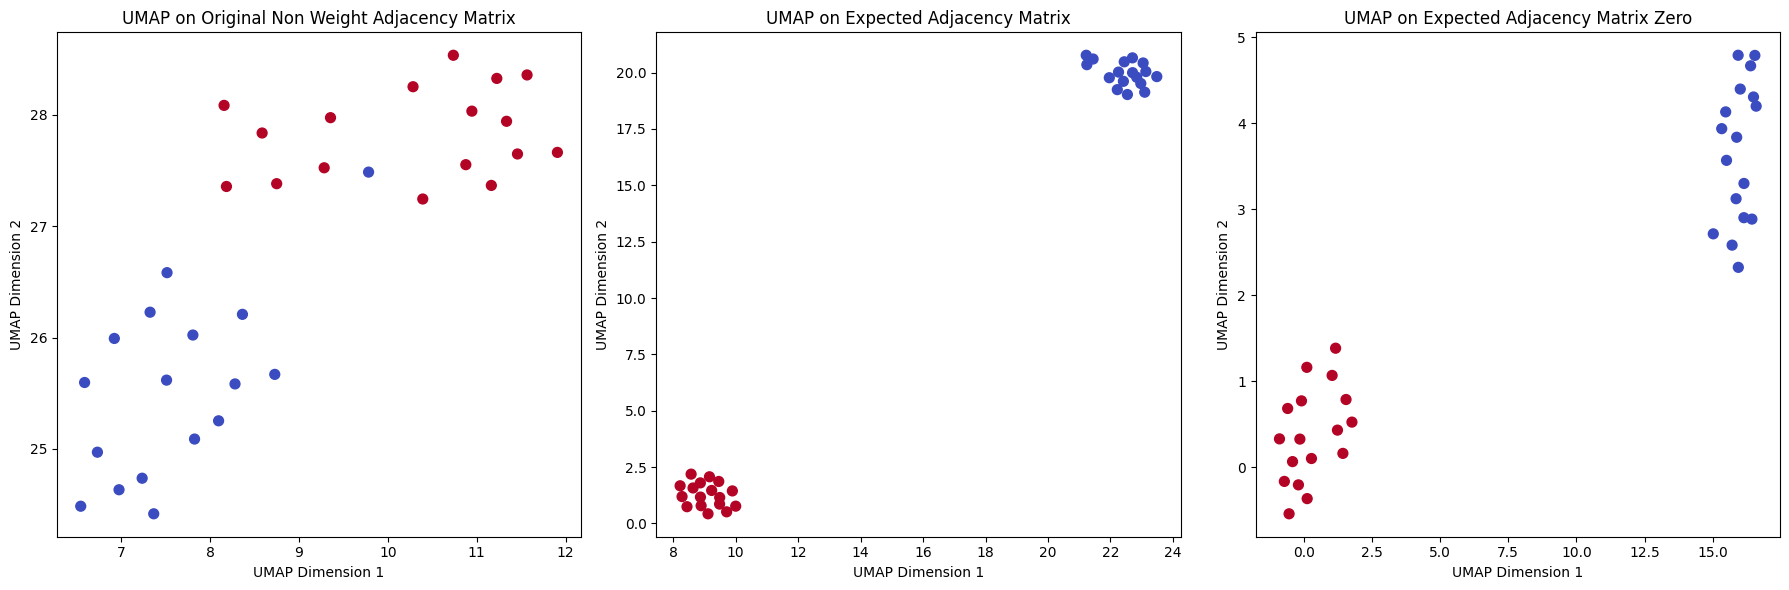

In [11]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, random_state=22, metric="cosine").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, random_state=22, metric="cosine").fit_transform(A_expected)
embedding_expected_zero = umap.UMAP(n_components=2, random_state=22, metric="cosine").fit_transform(A_expected_zero)

# 結果をプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=communities, cmap='coolwarm', s=50)
ax1.set_title('UMAP on Original Non Weight Adjacency Matrix')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
ax2.set_title('UMAP on Expected Adjacency Matrix')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

ax3.scatter(embedding_expected_zero[:, 0], embedding_expected_zero[:, 1], c=communities, cmap='coolwarm', s=50)
ax3.set_title('UMAP on Expected Adjacency Matrix Zero')
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

### SBMによる合成データ

In [13]:
def generate_sbm_graph(N, communities, p_in, p_out):
    # コミュニティ割り当てリストを作成
    sizes = [N // len(communities)] * len(communities)
    for i in range(N % len(communities)):
        sizes[i] += 1
    
    # 確率行列を作成
    p = p_out * np.ones((len(communities), len(communities)))
    for i in range(len(communities)):
        p[i, i] = p_in
    
    # SBMグラフを生成
    G = nx.stochastic_block_model(sizes, p)
    
    # コミュニティ割り当てを属性として追加
    node_to_comm = {}
    node_mapping = {}
    for i, node in enumerate(G.nodes()):
        node_mapping[node] = i
    G = nx.relabel_nodes(G, node_mapping)
    
    for i, comm in enumerate(communities):
        for j in range(sizes[i]):
            node_to_comm[sum(sizes[:i]) + j] = comm
    nx.set_node_attributes(G, node_to_comm, 'community')
    
    return G

In [11]:
N = 100
p_in = [0.9, 0.8, 0.7, 0.6, 0.5]
communities_2 = ['A', 'B']

  7%|▋         | 7/100 [00:00<00:00, 103.70it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2228.  396.]
 [ 396. 2284.]]
[[0.         0.92692315 0.90838468 ... 0.         0.         0.        ]
 [0.92692315 0.         0.82580426 ... 0.         0.         0.        ]
 [0.90838468 0.82580426 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.87159591 0.80186824]
 [0.         0.         0.         ... 0.87159591 0.         0.78614533]
 [0.         0.         0.         ... 0.80186824 0.78614533 0.        ]]


 12%|█▏        | 12/100 [00:00<00:00, 124.33it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2114. 1418.]
 [1418.  628.]]
[[0.         0.58273377 0.63986453 ... 0.51417685 0.         0.        ]
 [0.58273377 0.         0.54676726 ... 0.         0.         0.        ]
 [0.63986453 0.54676726 0.         ... 0.4824417  0.42883707 0.        ]
 ...
 [0.51417685 0.         0.4824417  ... 0.         0.34460122 0.42213649]
 [0.         0.         0.42883707 ... 0.34460122 0.         0.        ]
 [0.         0.         0.         ... 0.42213649 0.         0.        ]]


 15%|█▌        | 15/100 [00:00<00:00, 199.47it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2774. 1157.]
 [1157.  264.]]
[[0.         0.50552716 0.56878127 ... 0.37070028 0.         0.54690507]
 [0.50552716 0.         0.6152124  ... 0.         0.47457652 0.59155038]
 [0.56878127 0.6152124  0.         ... 0.45113186 0.         0.        ]
 ...
 [0.37070028 0.         0.45113186 ... 0.         0.34800434 0.43378063]
 [0.         0.47457652 0.         ... 0.34800434 0.         0.        ]
 [0.54690507 0.59155038 0.         ... 0.43378063 0.         0.        ]]


  7%|▋         | 7/100 [00:00<00:00, 212.71it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[1106. 1227.]
 [1227. 2366.]]
[[0.         0.55561454 0.628086   ... 0.         0.         0.        ]
 [0.55561454 0.         0.         ... 0.         0.         0.41168842]
 [0.628086   0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.59914139]
 [0.         0.41168842 0.         ... 0.         0.59914139 0.        ]]


 34%|███▍      | 34/100 [00:00<00:00, 211.33it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2780. 1373.]
 [1373.  414.]]
[[0.         0.         0.49236084 ... 0.         0.10339463 0.36104513]
 [0.         0.         0.49120293 ... 0.         0.         0.58997673]
 [0.49236084 0.49120293 0.         ... 0.         0.16245685 0.56728531]
 ...
 [0.         0.         0.         ... 0.         0.10564234 0.        ]
 [0.10339463 0.         0.16245685 ... 0.10564234 0.         0.        ]
 [0.36104513 0.58997673 0.56728531 ... 0.         0.         0.        ]]


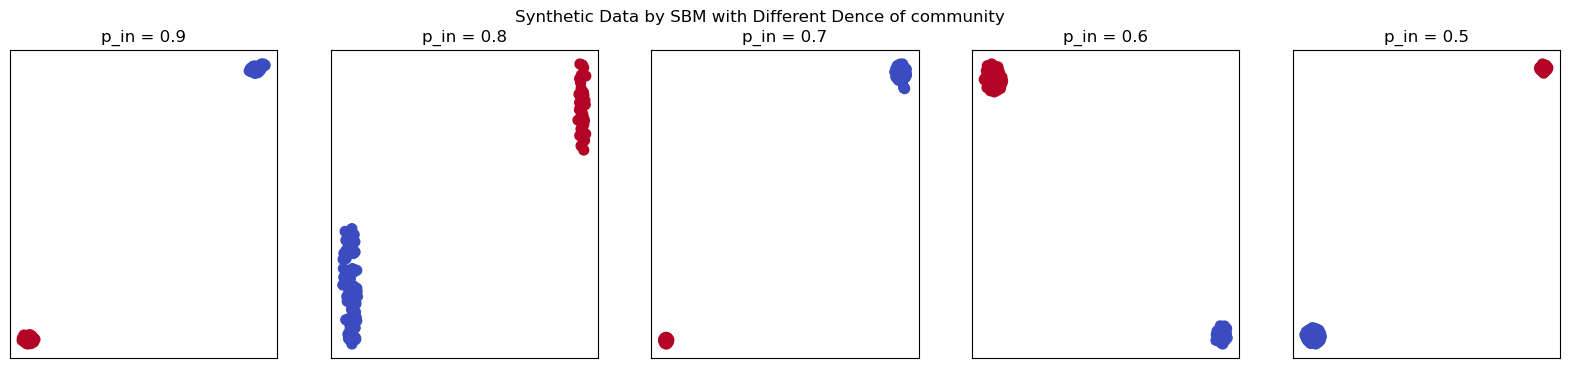

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Synthetic Data by SBM with Different Dence of community")
for i in range(len(p_in)):
    G = generate_sbm_graph(N, communities_2, p_in[i], 1.0-p_in[i])
    community_assignment_G = np.zeros(len(G.nodes()), dtype=int)
    for j in G.nodes():
        if G.nodes[j]['community'] == 'A':
            community_assignment_G[j] = 0
        elif G.nodes[j]['community'] == 'B':
            community_assignment_G[j] = 1
        else:
            community_assignment_G[j] = 2
        
    # 最も尤度関数の値の大きい学習結果を採用
    best_dcsbm = DCSBM_NW.DCSBM(G, 2, 22)
    best_dcsbm.fit()
    w = best_dcsbm.get_w()
    theta = best_dcsbm.get_theta()
    communities = best_dcsbm.get_communities()
    A_non_weight = best_dcsbm.calculate_adjancency_matrix_sub()
    avdg = int(best_dcsbm.get_mean_degree())
    A = nx.to_numpy_array(G)

    N = G.number_of_nodes()
    A_expected = np.zeros((N, N))

    for k in range(N):
        for l in range(N):
            A_expected[k][l] = theta[k]*theta[l]*w[communities[k]][communities[l]]

    A_expected_zero = A_expected*A_non_weight

    print(w)
    print(A_expected_zero)

    # embedding_orig = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_non_weight)
    embedding_expected = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected)
    # embedding_expected_zero = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected_zero)

    ax = axes[i]
    ax.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
    ax.set_title(f'p_in = {p_in[i]}')
    ax.set_xticks([])
    ax.set_yticks([])

  1%|          | 1/100 [00:00<00:02, 35.58it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2220.  223.]
 [ 223. 2192.]]
[[0.         0.86371061 0.92396949 ... 0.10817674 0.         0.10205353]
 [0.86371061 0.         0.73575348 ... 0.         0.         0.08126485]
 [0.92396949 0.73575348 0.         ... 0.         0.         0.        ]
 ...
 [0.10817674 0.         0.         ... 0.         0.95614418 0.99598352]
 [0.         0.         0.         ... 0.95614418 0.         0.90202281]
 [0.10205353 0.08126485 0.         ... 0.99598352 0.90202281 0.        ]]


  3%|▎         | 3/100 [00:00<00:01, 73.67it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[1996.  500.]
 [ 500. 1930.]]
[[0.         0.91501787 0.78942719 ... 0.         0.         0.        ]
 [0.91501787 0.         0.71894262 ... 0.         0.         0.        ]
 [0.78942719 0.71894262 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.66055818 0.        ]
 [0.         0.         0.         ... 0.66055818 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


 22%|██▏       | 22/100 [00:00<00:00, 121.61it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[1680.  743.]
 [ 743. 1688.]]
[[0.         0.67246598 0.         ... 0.         0.         0.        ]
 [0.67246598 0.         0.71538934 ... 0.31534827 0.         0.        ]
 [0.         0.71538934 0.         ... 0.31534827 0.         0.        ]
 ...
 [0.         0.31534827 0.31534827 ... 0.         0.69979141 0.62838413]
 [0.         0.         0.         ... 0.69979141 0.         0.61581644]
 [0.         0.         0.         ... 0.62838413 0.61581644 0.        ]]


  7%|▋         | 7/100 [00:00<00:01, 53.62it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[ 606. 1457.]
 [1457. 2346.]]
[[0.         0.         0.45983791 ... 0.         0.         0.        ]
 [0.         0.         0.43278863 ... 0.         0.43278863 0.21818279]
 [0.45983791 0.43278863 0.         ... 0.         0.         0.21363731]
 ...
 [0.         0.         0.         ... 0.         0.55334355 0.18681899]
 [0.         0.43278863 0.         ... 0.55334355 0.         0.21363731]
 [0.         0.21818279 0.21363731 ... 0.18681899 0.21363731 0.        ]]


 58%|█████▊    | 58/100 [00:00<00:00, 130.66it/s]
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[[2882. 1579.]
 [1579.  612.]]
[[0.         0.         0.42341593 ... 0.         0.         0.26690363]
 [0.         0.         0.49941367 ... 0.         0.12935914 0.        ]
 [0.42341593 0.49941367 0.         ... 0.5711835  0.15466854 0.37640256]
 ...
 [0.         0.         0.5711835  ... 0.         0.         0.3600501 ]
 [0.         0.12935914 0.15466854 ... 0.         0.         0.        ]
 [0.26690363 0.         0.37640256 ... 0.3600501  0.         0.        ]]


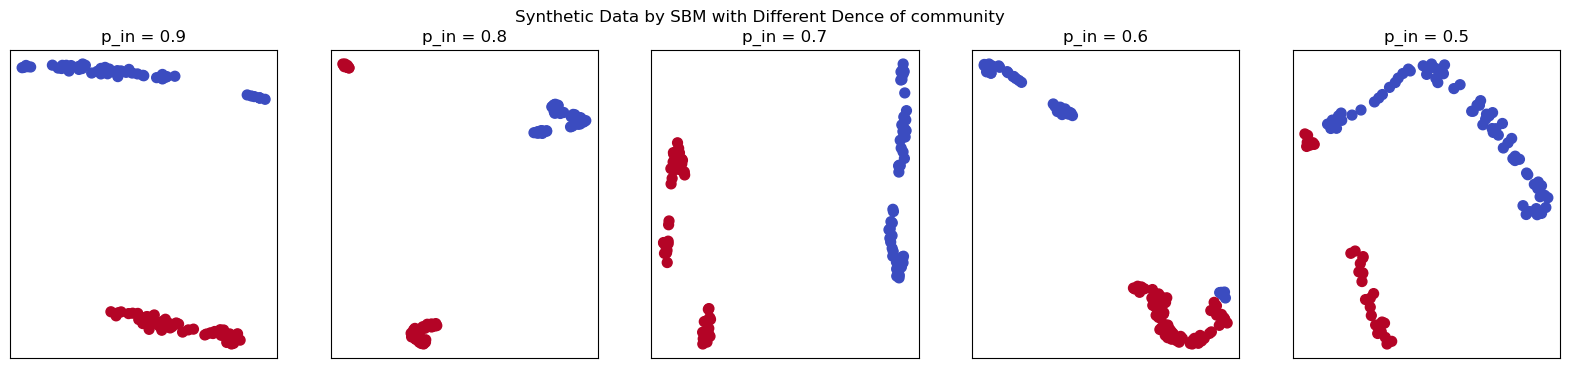

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Synthetic Data by SBM with Different Dence of community")
for i in range(len(p_in)):
    G = generate_sbm_graph(N, communities_2, p_in[i], 1.0-p_in[i])
    community_assignment_G = np.zeros(len(G.nodes()), dtype=int)
    for j in G.nodes():
        if G.nodes[j]['community'] == 'A':
            community_assignment_G[j] = 0
        elif G.nodes[j]['community'] == 'B':
            community_assignment_G[j] = 1
        else:
            community_assignment_G[j] = 2
        
    # 最も尤度関数の値の大きい学習結果を採用
    best_dcsbm = DCSBM_NW.DCSBM(G, 2, 22)
    best_dcsbm.fit()
    w = best_dcsbm.get_w()
    theta = best_dcsbm.get_theta()
    communities = best_dcsbm.get_communities()
    A_non_weight = best_dcsbm.calculate_adjancency_matrix_sub()
    avdg = int(best_dcsbm.get_mean_degree())
    A = nx.to_numpy_array(G)

    N = G.number_of_nodes()
    A_expected = np.zeros((N, N))

    for k in range(N):
        for l in range(N):
            A_expected[k][l] = theta[k]*theta[l]*w[communities[k]][communities[l]]

    A_expected_zero = A_expected*A_non_weight

    print(w)
    print(A_expected_zero)

    # embedding_orig = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_non_weight)
    embedding_expected = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="euclidean").fit_transform(A_expected)
    # embedding_expected_zero = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected_zero)

    ax = axes[i]
    ax.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=communities, cmap='coolwarm', s=50)
    ax.set_title(f'p_in = {p_in[i]}')
    ax.set_xticks([])
    ax.set_yticks([])